In [2]:
import numpy as np
import scipy as sp
import matplotlib as mpl
from matplotlib import pyplot as plt
import sys
import glob, re
import pandas as pd
import os
import natsort
import pickle 
import colorsys

from celluloid import Camera
from IPython.display import HTML

from definitions import *

# Galton board distribution

## $\tau_r$ sweep

In [38]:
# For ABP
parent_path = '/home/active-galton/runs/production/7a.GB_ABP/sweep_taur/' 
paths = os.listdir(parent_path)
paths_filt = np.array([p for p in paths if 'ts0.001' in p])
Trs = np.array([p.split('_')[6][2:] for p in paths_filt])
srtd_idxs = np.argsort(Trs.astype(float))
Trs = Trs[srtd_idxs].astype(float)
paths_srtd = paths_filt[srtd_idxs]

# For RTP
# parent_path = '/home/active-galton/runs/production/7b.GB_RTP/sweep_taur/' 
# paths = os.listdir(parent_path)
# paths_filt = np.array([p for p in paths if 'ts0.001' in p])
# alphas = np.array([p.split('_')[13][2:] for p in paths_filt])
# srtd_idxs = np.argsort(alphas.astype(float))
# alphas = alphas[srtd_idxs].astype(float)
# paths_srtd = paths_filt[srtd_idxs]

# # For passive
# parent_path = '/home/active-galton/runs_yago/final_product/7a.Fp0/' 
# paths = os.listdir(parent_path)
# paths_filt = np.array([p for p in paths if 'ts0.001' in p])
# paths_srtd = paths_filt


In [ ]:
sigma_obs = 6.9
selected_obstacle_row = -8

tot_countss = []
count_evols = []
parts_poss = []
for ii, path in enumerate(paths_srtd[:]):

    filenames = os.listdir(parent_path+path+'/Frames')
    filenames.sort(key=natural_sort_key)
    filenames_paths = [parent_path+path+'/Frames/'+f for f in filenames]
    
    # We load the some frames.
    try:
        del frames
    except:
        pass
        
    frames = load_frames(filenames_paths[:])
            
    frames_obs = frames[0]
    frames_part = frames[2:]

    # Position of the row of obstacles at which we want to compute the density
    obs_x_poss = np.unique(frames_obs.traj[frames_obs.traj['type']==2]['x'].to_numpy())
    dens_at_x = obs_x_poss[selected_obstacle_row]
    obs_y_poss_selected = np.unique(frames_obs.traj[frames_obs.traj['x']==dens_at_x]['y'].to_numpy())

    # Set up bins 
    bins = obs_y_poss_selected
    nbins = len(bins)
    bins_cent = bins[0:-1]+(bins[1]-bins[0])/(2*(nbins-1))

    # Initialize stuff
    obsrvd_ids = np.array([], dtype=np.int32)
    tot_counts = np.zeros(nbins-1)
    count_evol = np.zeros(nbins-1)
    parts_pos = []
    norm = 0

    # Loop over time frames
    for i,frame in enumerate(frames_part[:]):
        
        clear_output(wait=True)    

        # If the frame is not empty
        if not frame.traj.empty:

            # Get particles below selected obstacle and above next obstacle
            in_range_prtcls = frame.traj[(frame.traj['x'] > dens_at_x) & (frame.traj['x'] < dens_at_x+sigma_obs/2)]

            # Get their id
            ids = np.array(in_range_prtcls['id'].tolist())

            # Compare with observed so that we don't count twice
            new_ids = np.invert(np.in1d(ids, obsrvd_ids))

            # Compute histogram only for the new ids
            count,_ = np.histogram(in_range_prtcls[new_ids]['y'].tolist(), bins=bins, density=True)

            # Transform nan to 0
            count_nan2num = np.nan_to_num(count)

            # If the histogram is not empty
            if count_nan2num.any():
                
                norm+=1

                # Normalize histogram for each time frame
                count_nan2num_norm = count_nan2num / np.sum(count_nan2num)

                # Acumulate histogram in total histogram
                tot_counts += count_nan2num_norm

                # Append each histogram to track also evolution and time-normarlize
                count_evol = np.vstack((count_evol, tot_counts/norm))

                # Update observed ids
                obsrvd_ids = np.append(obsrvd_ids, ids[new_ids])

                # Append particles positions to later compute the kurtosis
                parts_pos.append(in_range_prtcls[new_ids]['y'].tolist())

        print([np.round(100*ii/len(paths_srtd),1), np.round(100*i/len(frames_part),1)])    
    
    tot_counts /= norm
    tot_countss.append(tot_counts)
    count_evols.append(count_evol)
    parts_poss.append(parts_pos)
    
tot_countss = np.array(tot_countss)
count_evols = np.array(count_evols, dtype=object)
parts_poss = np.array(parts_poss,dtype=object)

In [99]:
gamma_r = 3
dt = 0.001

Dr = Trs / gamma_r
tau_r_abp = 1 / Dr
tau_r_rtp = dt / alphas

var = tau_r_abp

plt.rcParams['font.size'] = 16
fig, ax = plt.subplots();
normalize = mpl.colors.Normalize(vmin=var.min(), vmax=var.max())
colormap = mpl.cm.jet

for i, counts in enumerate(tot_countss):
    a=ax.plot(bins_cent, counts, lw=1.5, color=colormap(normalize(var[i])));

ax.set_yscale('log')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$P(x)$')
ax.set_ylim(0.00001,0.07)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
fig.colorbar(sm, ax=ax, label=r'$\tau_r$')
fig.set_tight_layout(True)

In [3]:
# Save plot and data
name='GB-ABP_out-prob-dens_with-passive'
results_path_main="/home/active-galton/results/3.ABP-RTP_galton-board/"

fig.savefig(results_path_main+name+'.png',dpi=200)

probdensdata = {
    'bins': bins_cent,
    'rot_temp': Trs,
    'probdens': tot_countss
}

with open(results_path_main+name+'.pkl', 'wb') as f:
    pickle.dump(probdensdata, f)

## Check normalization

0.9999999999999999

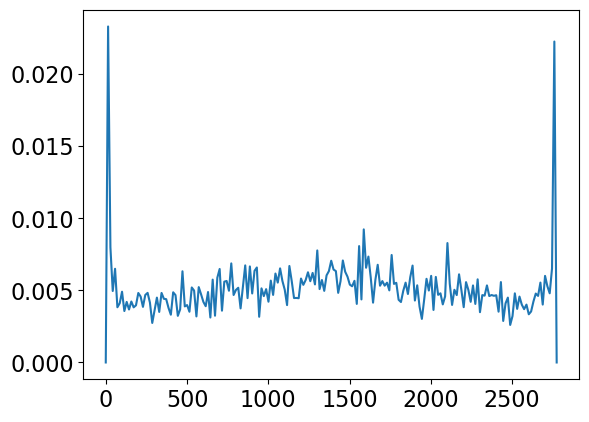

In [100]:
# Check that it is a density distribution (integral = 1)
pd = tot_countss[0]
plt.plot(bins_cent,pd)
np.trapz(pd)

## Zoom on edge

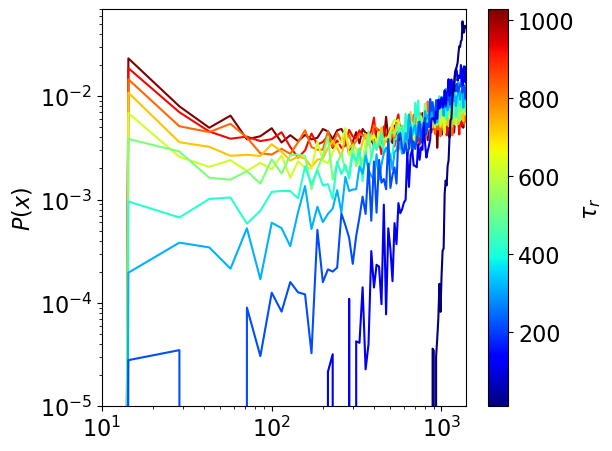

In [101]:
gamma_r = 3
dt = 0.001
Dr = Trs / gamma_r
tau_r_abp = 1 / Dr
tau_r_rtp = dt / alphas
var = tau_r_rtp

plt.rcParams['font.size'] = 16
fig, ax = plt.subplots();
normalize = mpl.colors.Normalize(vmin=var.min(), vmax=var.max())
colormap = mpl.cm.jet

for i, counts in enumerate(tot_countss):
    a=ax.plot(bins_cent, counts, lw=1.5, color=colormap(normalize(var[i])));

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$P(x)$')
ax.set_xlim(10,bins_cent[-1]/2)
ax.set_ylim(0.00001,0.07)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
fig.colorbar(sm, ax=ax, label=r'$\tau_r$')
fig.set_tight_layout(True)

## Plot everything together

In [47]:
# Load ABP
name='GB-ABP_out-prob-dens'
results_path_main="/home/active-galton/results/3.ABP-RTP_galton-board/"
data = np.load(results_path_main+name+'.pkl',allow_pickle=True)

tot_countss_abp = data['probdens']
Trs = data['rot_temp']
bins_cent_abp = data['bins']

# Load RTP
name='GB-RTP_out-prob-dens'
results_path_main="/home/active-galton/results/3.ABP-RTP_galton-board/"
data = np.load(results_path_main+name+'.pkl',allow_pickle=True)

tot_countss_rtp = data['probdens']
alphas = data['alpha']
bins_cent_rtp = data['bins']

# Load passive
name='GB-passive_out-prob-dens'
results_path_main="/home/active-galton/results/3.ABP-RTP_galton-board/"
data = np.load(results_path_main+name+'.pkl',allow_pickle=True)

tot_countss_pass = data['probdens']
bins_cent_pass = data['bins']

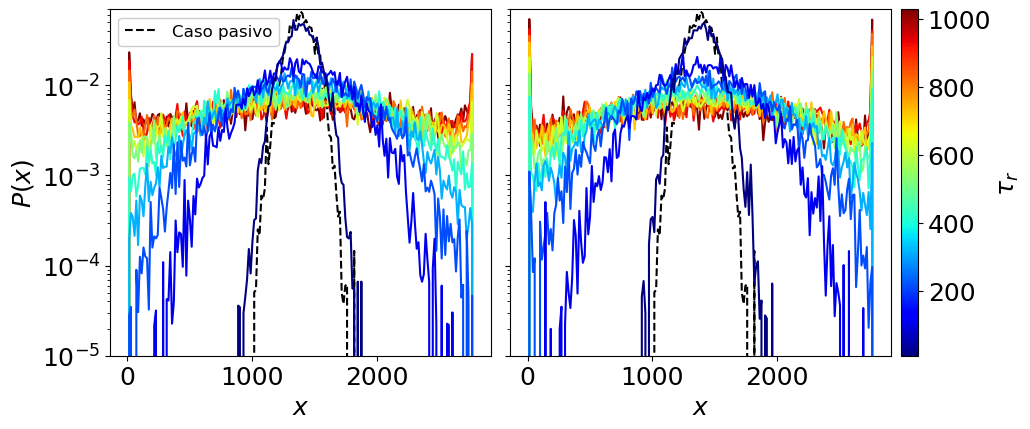

In [109]:
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(1,2,sharey=True,figsize=(1.5*2*4,1.5*3), gridspec_kw = {'wspace':0.05, 'hspace':0});

# Passive case
ax[0].plot(bins_cent_pass, tot_countss_pass[0], lw=1.5, color='k',ls='dashed', label='Caso pasivo');
ax[1].plot(bins_cent_pass, tot_countss_pass[0], lw=1.5, color='k',ls='dashed', label='Caso pasivo');

# ABP
gamma_r = 3
Dr = Trs / gamma_r
tau_r = 1 / Dr
var=tau_r
normalize = mpl.colors.Normalize(vmin=var.min(), vmax=var.max())
colormap = mpl.cm.jet
for i, counts in enumerate(tot_countss_abp):
    ax[0].plot(bins_cent_abp, counts, lw=1.5, color=colormap(normalize(var[i])));

ax[0].set_yscale('log')
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$P(x)$')
ax[0].set_ylim(0.00001,0.07)
sm0 = plt.cm.ScalarMappable(cmap=colormap, norm=normalize)
ax[0].legend(fontsize=12,framealpha=1,loc='upper left')

# RTP
dt = 0.001
tau_r = dt / alphas
var=tau_r
normalize = mpl.colors.Normalize(vmin=var.min(), vmax=var.max())
colormap = mpl.cm.jet
for i, counts in enumerate(tot_countss_rtp):
    ax[1].plot(bins_cent_rtp, counts, lw=1.5, color=colormap(normalize(var[i])));

ax[1].set_yscale('log')
ax[1].set_xlabel(r'$x$')
ax[1].set_ylim(0.00001,0.07)

fig.colorbar(sm0, ax=ax.ravel().tolist(), label=r'$\tau_r$', pad=0.01)


In [110]:
# Save plot and data
name='GB-active_out-prob-dens_with-passive'
results_path_main="/home/active-galton/results/3.ABP-RTP_galton-board/"

fig.savefig(results_path_main+name+'.png',dpi=200, bbox_inches='tight')


## Kurtosis

In [111]:
poss = []
for p in parts_poss:
    pos = []
    for pp in p:
        for ppp in pp:
            pos.append(ppp)
    poss.append(pos)
    

In [112]:
kurts = [sp.stats.kurtosis(p) for p in poss]


Text(0.5, 0, '$T_r$')

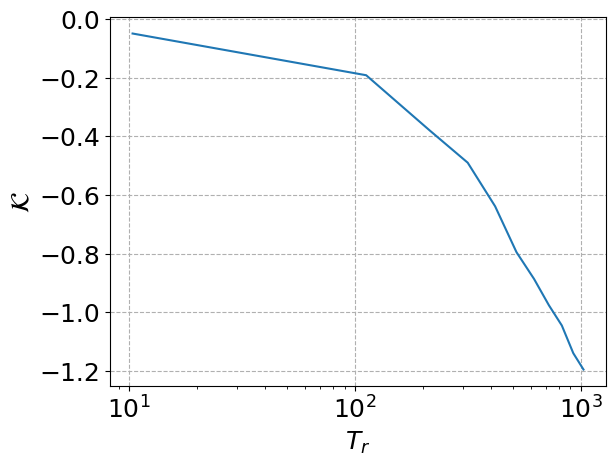

In [113]:
fig,ax = plt.subplots()
ax.plot(tau_r_abp, kurts)

ax.grid(ls='--')
ax.set_xscale('log')
ax.set_ylabel(r'$\mathcal{K}$')
ax.set_xlabel(r'$T_r$')

In [ ]:
# Save plot and data
name='GB-ABP_kurtosis'

data = {
    'tau_r': tau_r_abp,
    'kurtosis': kurts,
}

with open(results_path_main+name+'.pkl', 'wb') as f:
    pickle.dump(data, f)

### Plot together

In [128]:
# Load Data
name='GB-ABP_kurtosis'
results_path_main="/home/active-galton/results/3.ABP-RTP_galton-board/"
data = np.load(results_path_main+name+'.pkl',allow_pickle=True)

tau_r_abp = data['tau_r']
kurts_abp = data['kurtosis']

# Load Data
name='GB-RTP_kurtosis'
results_path_main="/home/active-galton/results/3.ABP-RTP_galton-board/"
data = np.load(results_path_main+name+'.pkl',allow_pickle=True)

tau_r_rtp = data['tau_r']
kurts_rtp = data['kurtosis']


In [133]:
dt = 0.01

fig,ax = plt.subplots()
ax.plot(tau_r_abp, kurts_abp)
ax.plot(tau_r_rtp, kurts_rtp)

ax.grid(ls='--')
# ax.set_xscale('log')
ax.set_ylabel(r'$\mathcal{K}$')
ax.set_xlabel(r'$\tau_r$')
ax.legend(["ABP","RTP"])


In [22]:
# Save plot and data
name='GB_kurtosis'

fig.savefig(results_path_main+name+'.png',dpi=200)
